<a href="https://colab.research.google.com/github/Satya-Iswarya/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file 1/0 (e.g. pd.read_csv)
import os # to use operating system dependent functionality
import librosa # to extract speech features
import wave # read and write WAV files
import matplotlib.pyplot as plt # to generate the visualizations
#MLP Classifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
# LSTM Classifier
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import RMSprop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#This function extracts mfcc features and obtain the mean of each dimension
    #Input: path_to_wav_file
    #Output: mfcc_features

In [ ]:
def extract_mfcc(wav_file_name):
    y, sr = librosa.load(wav_file_name)
    mfccs= np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)

    return mfccs

##### Load radvess speech data #####

In [ ]:
radvess_speech_labels = [] # to save extracted label/file
ravdess_speech_data = [] #to save extracted features/file
for dirname, _, filenames in os.walk('/content/drive/MyDrive/ravdess-emotional-speech-audio'):
  for filename in filenames:
    radvess_speech_labels.append(int(filename [7:8])-1) # the index 7 and 8 of the file name represent the emotion label
    wav_file_name = os.path.join(dirname, filename)
    ravdess_speech_data.append(extract_mfcc(wav_file_name)) # extract MFCC features/file
print("Finish Loading the Dataset")

Finish Loading the Dataset


In [1]:
#ravdess_speech_data

In [ ]:
#### convert data and label to array
ravdess_speech_data_array = np.asarray(ravdess_speech_data) # convert the input to an array
ravdess_speech_label_array = np.array (radvess_speech_labels)
ravdess_speech_label_array.shape # get tuple of array dimensions
#### make categorical labels
labels_categorical=to_categorical (ravdess_speech_label_array) # converts a class vector (integers) to binary class matrix
labels_categorical.shape

(2880, 8)

In [ ]:
ravdess_speech_data_array.shape

(2880, 40)

In [ ]:
x_train,x_test,y_train,y_test= train_test_split(np.array(ravdess_speech_data_array), labels_categorical, test_size=0.20, random_state=9)

In [ ]:
#Split the training, validating, and testing sets
number_of_samples = ravdess_speech_data_array.shape[0]
training_samples=int(number_of_samples * 0.8)
validation_samples=int(number_of_samples * 0.1)
test_samples=int (number_of_samples * 0.1)

In [ ]:
#Define the LSTM model
def create_model_LSTM(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(8, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
w=np.expand_dims(ravdess_speech_data_array[:training_samples],-1)

In [ ]:
w.shape

(2304, 40, 1)

In [ ]:
# Evaluate on unseen test data (add channel dimension)
model_A = create_model_LSTM(np.expand_dims(ravdess_speech_data_array[:training_samples], -1).shape[1:])
test_loss, test_acc = model_A.evaluate(np.expand_dims(x_test, -1), y_test)
print("Test Accuracy:", test_acc)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0932 - loss: 2.0845
Test Accuracy: 0.0763888880610466


In [ ]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (2304, 40)
x_test shape: (576, 40)
y_train shape: (2304, 8)
y_test shape: (576, 8)


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
# Step 1: Split data properly
x_train, x_test, y_train, y_test = train_test_split(
    np.array(ravdess_speech_data_array), np.array(labels_categorical), test_size=0.2, random_state=42, shuffle=True
)

# Step 2: Scale features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Step 3: Reshape for LSTM (samples, timesteps, features=1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Step 4: Build LSTM model with Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 5: Early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 6: Train the model
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

# Step 7: Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_acc)

# Step 8: Confusion matrix & classification report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true, y_pred_classes))

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.1567 - loss: 2.0522 - val_accuracy: 0.2256 - val_loss: 1.9644
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.2364 - loss: 1.9290 - val_accuracy: 0.2690 - val_loss: 1.8600
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.2999 - loss: 1.8416 - val_accuracy: 0.3037 - val_loss: 1.8233
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.2926 - loss: 1.8378 - val_accuracy: 0.2885 - val_loss: 1.8040
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.2879 - loss: 1.8369 - val_accuracy: 0.3189 - val_loss: 1.7941
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.3087 - loss: 1.7732 - val_accuracy: 0.3124 - val_loss: 1.7935
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.3162 - loss: 1.7623 - val_accuracy: 0.2907 - val_loss: 1.7827
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.3043 - loss: 1.7633 - val_accuracy: 0.2907 - va

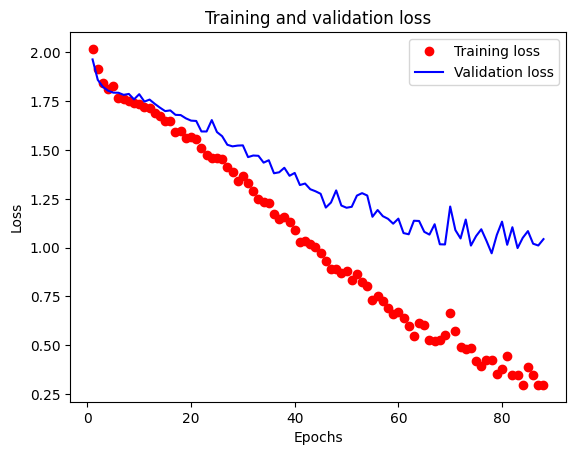

In [ ]:
### loss plots using LSTM model
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

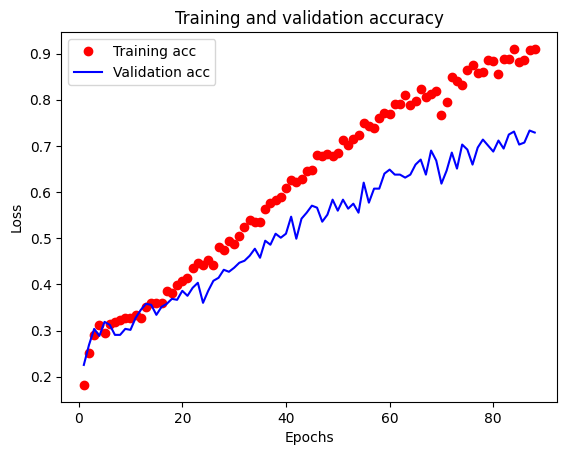

In [ ]:
### accuracy plots using LSTM model
plt.clf()
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
### evaluate using model A
model_A.evaluate(np.expand_dims(ravdess_speech_data_array[training_samples + validation_samples:], -1), labels_categorical[training_samples + validation_samples:])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0489 - loss: 2.0894


[2.083123207092285, 0.0694444477558136]

In [ ]:
emotions={1 : 'neutral', 2 : 'calm', 3 : 'happy', 4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disgust', 8:'surprised'}
def predict(wav_filepath):
  test_point=extract_mfcc(wav_filepath)
  test_point=np.reshape(test_point,newshape=(1,40,1))
  predictions=model_A.predict(test_point)
  print(emotions[np.argmax(predictions[0])+1])

In [ ]:
predict('/content/drive/MyDrive/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
neutral


In [ ]:
predict('/content/drive/MyDrive/ravdess-emotional-speech-audio/Actor_02/03-01-08-01-01-01-02.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
neutral


In [ ]:
predict('/content/drive/MyDrive/ravdess-emotional-speech-audio/Actor_02/03-01-03-01-01-01-02.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
neutral


In [ ]:
predict('/content/drive/MyDrive/ravdess-emotional-speech-audio/Actor_12/03-01-01-01-01-01-12.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
neutral


In [ ]:
model_A.save('mymodel.h5')

In [ ]:
from google.colab import files
files.download('mymodel.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>